# Tutorial 7: 2D Anisotropic Diffusion, non coercive case

In this tutorial, we consider the study and analysis of the eigenvalue problem associated to the following anisotropic diffusion operator
$$
    - \nabla \cdot \mathbf{b} \otimes \mathbf{b} \nabla \phi = \omega^2 \phi
$$
where $\mathbf{b} = (\iota, 1)$ is the normalized vector of the magnetic field.

In fact, the original problem is 3D and the iota profile is given as

$$
    \iota(r) = 0.47262 + 0.32392 r + 0.49604 r^2 + 5.3991 . 10^{-6} r^3 - 3.165 . 10^{-5} r^4 + 4.7963 . 10^{-5} r^5 - 2.2824 . 10^{-5} r^6
$$

which is the LHD-$\iota$-profile. Now taking the given radius $r = 0.9$ we get

$$
\mathbf{b} = (b_1,b_2)^\top = (1.1659397624413860850012270020670, 1. )^\top
$$

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

from vale import construct_model
import numpy as np
import os
import clapp.common.utils      as clapp_utils

# ... initializing Clapp
clapp_utils.initialize()
# ...

# ...
def construct_pde(filename, mapping, discretization):
    # ... clean input directory. needed for Fortran
    cmd = "rm -rf input"
    os.system(cmd)
    # ...

    # ... creates discretization parameters
    from clapp.disco.parameters.bspline import BSpline

    bspline_params = BSpline(discretization["n_elements"], \
                             discretization["degrees"], \
                             bc_min=[1,1], \
                             bc_max=[1,1])
    # ...

    # ... create a context from discretization
    from clapp.fema.context        import Context

    context = Context(dirname="input", \
                      discretization_params=bspline_params)
    # ...

    # ...
    pde = construct_model(filename, backend="clapp", \
                          context=context, mapping=mapping)
    # ...
    
    # ... clean input directory
    cmd = "rm -rf input"
    os.system(cmd)
    # ...
    
    return pde
# ...

We use **CAID** to create the geometry, then convert it to the *mapping* object from *CLAPP*

In [2]:
# ... creates a unit line geometry using CAID
from caid.cad_geometry import square
geometry = square()
# ...
    
# ...
from clapp.spl.mapping import Mapping
mapping = Mapping(geometry=geometry)
# ...

We specify the discretization, by giving the number of elements and spline degrees in every direction

In [3]:
# ... define a discretization
discretization = {"n_elements": [128,128], "degrees": [3,3]}
# ...

The following flag allows to assemble the involved matrices

In [4]:
with_matrix = False

In [5]:
pde = construct_pde(filename="../../glt/tests/2d/inputs/anisotropic_diffusion_2.vl", 
                    mapping=mapping, 
                    discretization=discretization)

form_a = pde["a"]
b1     = pde["b1"]
b2     = pde["b2"]

b1.set("1.1659397624413860850012270020670")
b2.set("1.0")

# ... compute the glt symbol and evaluate it
from glt.expression import glt_symbol_from_weak_formulation

expr_a = glt_symbol_from_weak_formulation(form_a, 
                                          verbose=False, evaluate=True, 
                                          discretization=discretization)
# ...

In [6]:
#from IPython.display import Math;
#from glt.printing.latex import glt_latex;
#Math(glt_latex(expr_a))

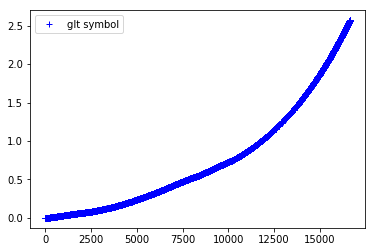

In [7]:
from glt.expression import glt_approximate_eigenvalues
t = glt_approximate_eigenvalues(expr_a, discretization)
t.sort()
plt.plot(t, "+b", label="glt symbol")       
# ...
if with_matrix:
    # ... assembling the linear system
    form_a.assembler.assemble()
    # ...
    
    # ...
    from scipy.linalg import eig
    M = form_a.matrix.get().todense()
    w, v = eig(M)
    wr = w.real
    wr.sort()
    plt.plot(wr, "xr", label="eigenvalues")
    # ...
# ...
plt.legend(loc=2);

In [8]:
pde_c = construct_pde(filename="../../glt/tests/2d/inputs/mass.vl", 
                    mapping=mapping, 
                    discretization=discretization)

form_c = pde_c["c"]

# ... compute the glt symbol and evaluate it
from glt.expression import glt_symbol_from_weak_formulation

expr_c = glt_symbol_from_weak_formulation(form_c, 
                                          verbose=False, evaluate=True, 
                                          discretization=discretization)
# ...

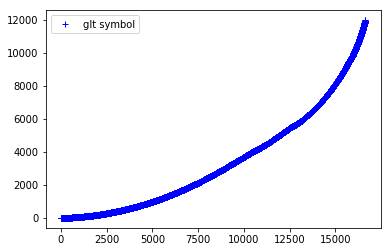

In [9]:
from glt.expression import glt_approximate_eigenvalues
t_a = glt_approximate_eigenvalues(expr_a, discretization)
t_c = glt_approximate_eigenvalues(expr_c, discretization)
t = t_a / t_c
t = t / (4 * np.pi**2) 

t.sort()
plt.plot(t, "+b", label="glt symbol")       
# ...

if with_matrix:
    # ...
    from scipy.linalg import eig
    A = form_a.matrix.get().todense()
    C = form_c.matrix.get().todense()
    w, v = eig(A, C)
    wr = w.real
    wr.sort()
    plt.plot(wr, "xr", label="eigenvalues")
    # ...
# ...
plt.legend(loc=2);

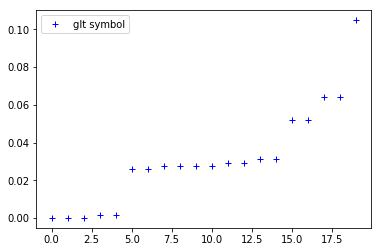

In [10]:
plt.plot(t[:20], "+b", label="glt symbol")

if with_matrix:
    plt.plot(wr[:20], "xr", label="eigenvalues")
plt.legend(loc=2);

In [11]:
print t[:10]

[ -5.77529016e-14   2.31207390e-05   2.31207390e-05   1.44473138e-03
   1.44473138e-03   2.61204655e-02   2.61204655e-02   2.72814880e-02
   2.72814880e-02   2.75360048e-02]


Since the glt symbols can be evaluated, let's plot their ratio 

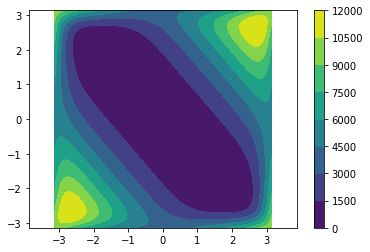

In [21]:
# ... lambdify the glt symbol
from glt.expression import glt_lambdify

f_a = glt_lambdify(expr_a, dim=2)
f_c = glt_lambdify(expr_c, dim=2)
# ...

# ... compute the symbol f_a / f_c
#nx = 100 ; ny = 100
nx,ny = discretization["n_elements"]
t1 = np.linspace(-np.pi,np.pi, nx+1)
t2 = np.linspace(-np.pi,np.pi, ny+1)

u = np.linspace(0.,1.,nx+1)
v = np.linspace(0.,1.,ny+1)

x = mapping.evaluate(u,v)[0,:,:]
y = mapping.evaluate(u,v)[1,:,:]

t1, t2 = np.meshgrid(t1, t2)

f = f_a(x,y,t1,t2)/f_c(x,y,t1,t2);
f = f / (4 * np.pi**2)
# ...

# ... plot
plt.contourf(t1, t2, f)
plt.axis("equal")
plt.colorbar();
# ...

In [22]:
print f[0,:].min()
print f.min()
print f[0,0]
print np.argmin(f.ravel())
f.ravel()[7238]

4101.29079159
-5.77529016375e-14
9676.64918525
8320


4466.4324901080845

In [23]:
b_1 = 1.1659397624413860850012270020670 ; b_2 = 1.0
N = discretization["n_elements"][0] ; M = discretization["n_elements"][1]
n = range(-N/2, N/2+1) 
m = range(-M/2, M/2+1)
n,m = np.meshgrid(n,m)
e = (b_1*n + b_2*m)**2 

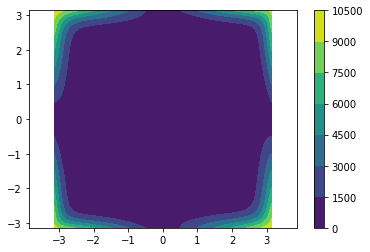

In [24]:
# ... plot
plt.contourf(t1, t2, np.abs(e-f))
plt.axis("equal")
plt.colorbar();
# ...

In [25]:
d = e-f
f[64,64]

-5.7752901637470983e-14

In [30]:
def mode(i,j, exact=False):
    N = discretization["n_elements"][0] ; M = discretization["n_elements"][1]
    if not exact:
        return f[N/2+i,M/2+j]
    else:
        return f[N/2+i,M/2+j], e[N/2+i,M/2+j]

In [31]:
mode(1,-1)

0.027536004760888733

In [32]:
mode(2,-2)

0.1101440193211199

In [29]:
for i in range(-10,10+1):
    for j in range(-10,10+1):
        v = mode(i,j)
        if v < 0.2:
            print "(", i, ",", j, ")", v

( -9 , 8 ) 0.107303786706
( -8 , 7 ) 0.0261204654882
( -7 , 6 ) 2.3120739025e-05
( -6 , 5 ) 0.0290035920914
( -5 , 4 ) 0.113058209688
( -2 , 2 ) 0.110144019321
( -1 , 1 ) 0.0275360047609
( 0 , 0 ) -5.77529016375e-14
( 1 , -1 ) 0.0275360047609
( 2 , -2 ) 0.110144019321
( 5 , -4 ) 0.113058209688
( 6 , -5 ) 0.0290035920914
( 7 , -6 ) 2.3120739025e-05
( 8 , -7 ) 0.0261204654882
( 9 , -8 ) 0.107303786706


In [33]:
for i in range(-10,10+1):
    for j in range(-10,10+1):
        v, w = mode(i,j, exact=True)
        if v < 0.2:
            print "(", i, ",", j, ")", v, "***", w, "***", np.abs(v-w)

( -9 , 8 ) 0.107303786706 *** 0.10726810552 *** 3.56811857628e-05
( -8 , 7 ) 0.0261204654882 *** 0.0261075590167 *** 1.29064714945e-05
( -7 , 6 ) 2.3120739025e-05 *** 1.90220310983e-05 *** 4.0987079267e-06
( -6 , 5 ) 0.0290035920914 *** 0.0290024945637 *** 1.09752768093e-06
( -5 , 4 ) 0.113058209688 *** 0.113057976615 *** 2.33072934591e-07
( -2 , 2 ) 0.110144019321 *** 0.110144019036 *** 2.84705314879e-10
( -1 , 1 ) 0.0275360047609 *** 0.0275360047591 *** 1.78508596793e-12
( 0 , 0 ) -5.77529016375e-14 *** 0.0 *** 5.77529016375e-14
( 1 , -1 ) 0.0275360047609 *** 0.0275360047591 *** 1.78508596793e-12
( 2 , -2 ) 0.110144019321 *** 0.110144019036 *** 2.84705314879e-10
( 5 , -4 ) 0.113058209688 *** 0.113057976615 *** 2.33072934591e-07
( 6 , -5 ) 0.0290035920914 *** 0.0290024945637 *** 1.09752768093e-06
( 7 , -6 ) 2.3120739025e-05 *** 1.90220310983e-05 *** 4.0987079267e-06
( 8 , -7 ) 0.0261204654882 *** 0.0261075590167 *** 1.29064714945e-05
( 9 , -8 ) 0.107303786706 *** 0.10726810552 *** 3.5

In [15]:
# ... Finalizing Clapp
clapp_utils.finalize()
# ...